# Load Libraries

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import re
import requests,io

import astroalign

from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable, Table
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper
from shapely.geometry import LineString, Point
from scipy import interpolate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib.colors import LogNorm

# Load the reduced data

In [43]:
data_path = 'data/reduced'

In [44]:
data = {}
data["M29B"] = np.load(f'{data_path}/M29B.npy')
data["M29V"] = np.load(f'{data_path}/M29G.npy')

In [45]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)


In [46]:
error = {}
error["M29B"] = np.load(f'{data_path}/M29B_error.npy')
error["M29V"] = np.load(f'{data_path}/M29G_error.npy')[0]

# Background Estimation


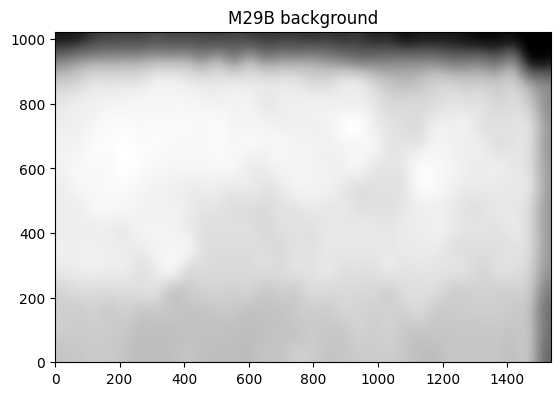

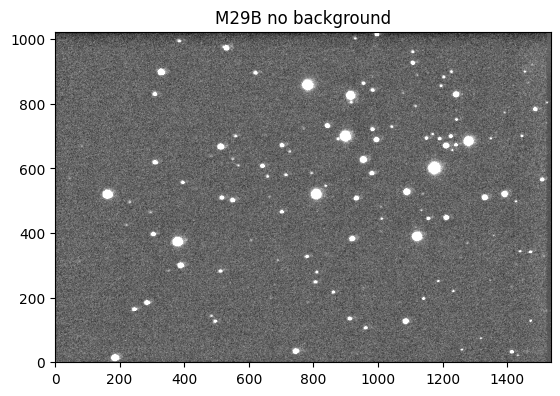

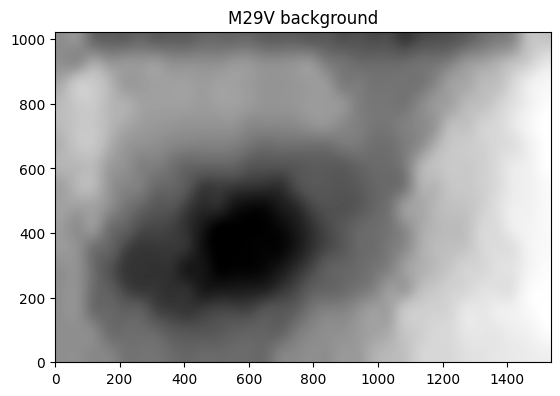

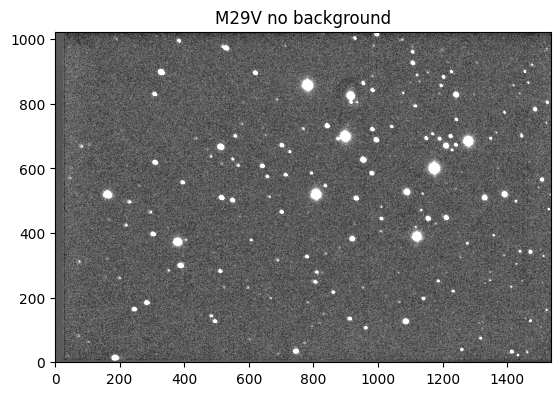

In [47]:
bkgs={}
bkg_uncs = {}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    lo,up= np.percentile(image-bkg.background,1),np.percentile(image-bkg.background,99)
    plt.imshow(image-bkg.background, cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

    data[key] = image - bkg.background




# Get 2D FWHM

Found 90 stars in image M29B


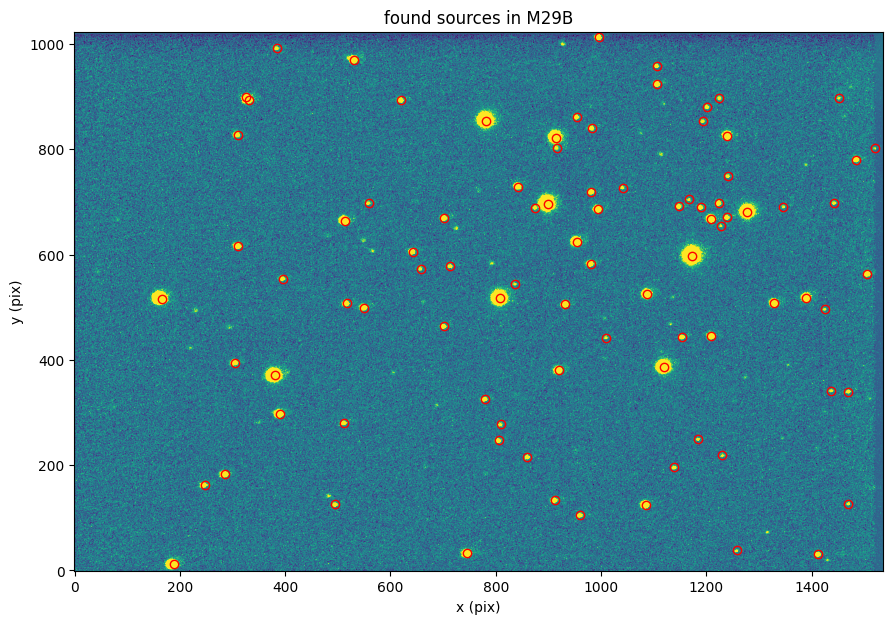

     x-FWHM 5.289131542312301+/-0.13607480433694988 (pix) for this M29B 
     y-FWHM 6.059529251279225+/-0.16848856733894454 (pix) for this M29B 
     FWHM 5.674330396795764+/-0.15109862742135563 (pix) for this M29B 
Found 142 stars in image M29V


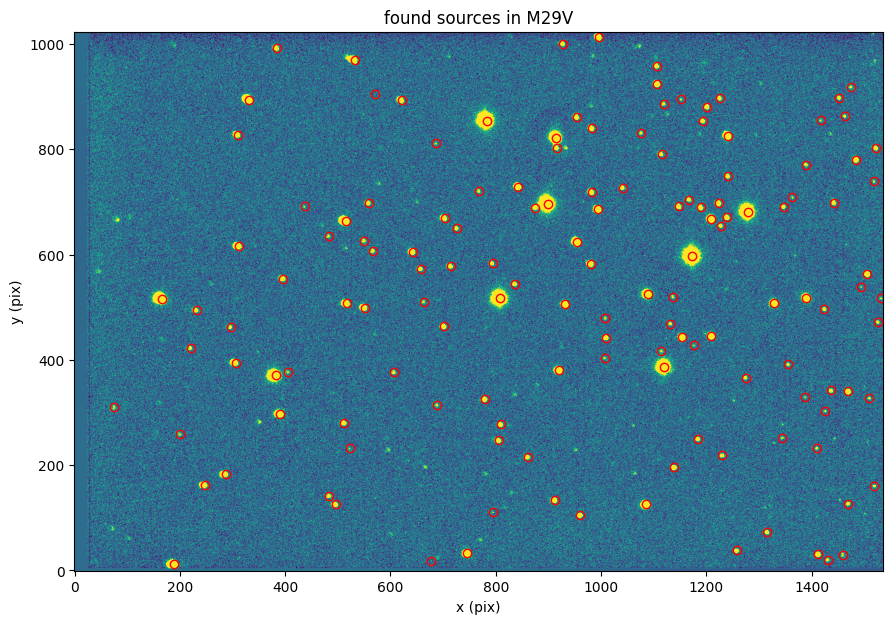

     x-FWHM 5.63515967707049+/-0.25766798797460627 (pix) for this M29V 
     y-FWHM 4.919274796716662+/-0.30736998551824285 (pix) for this M29V 
     FWHM 5.2832454132910724+/-0.24170618626175716 (pix) for this M29V 


In [48]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=5.5, threshold=6.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [49]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')


    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [50]:
fwhms

{'M29B': 5.674330396795764, 'M29V': 5.2832454132910724}

Found 92 stars in image M29B


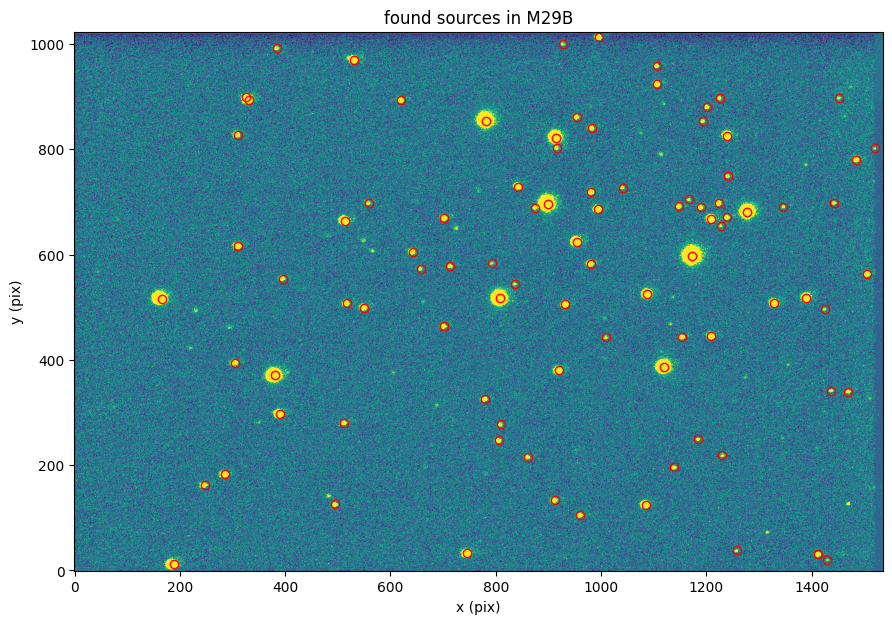

Found 142 stars in image M29V


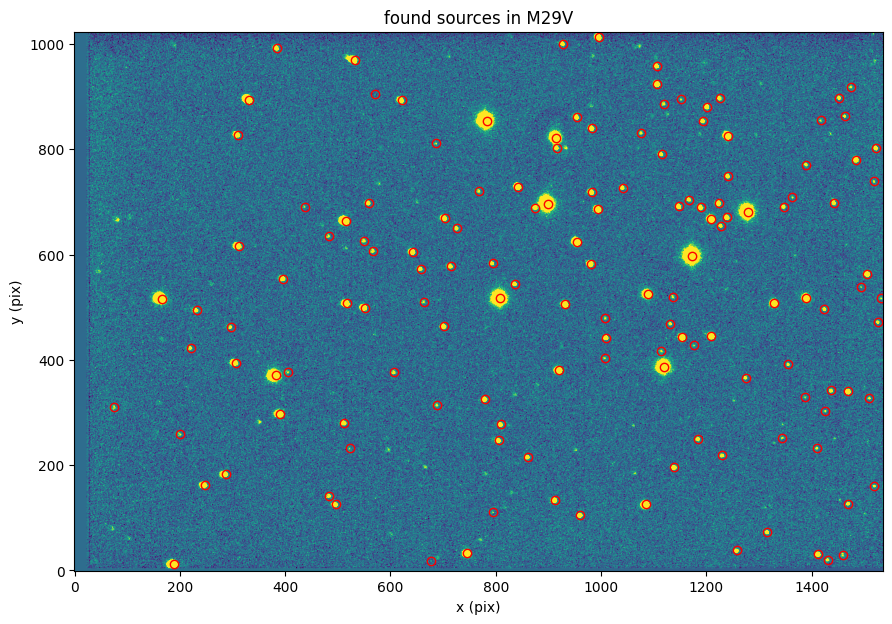

In [51]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=fwhms[key], threshold=6.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1]#[0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)

In [52]:
phots = {}

for key, image in data.items():

    group = SourceGrouper(fwhms[key])
    PSF = PSFPhotometry(
        grouper=group ,     
        psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
        finder=daofinds[key],
        fit_shape=(3,3), #play with this, this may be small
        aperture_radius=5 ,#play with this as well
        fitter_maxiters=500
    )
    init_params = QTable()
    init_params['x'] = x_inits[key]
    init_params['y'] = y_inits[key]

    phots[key] = PSF(image, 
                        init_params = init_params,
                        error=np.sqrt(np.square(bkg_uncs[key])+np.square(error[key])), 
                )

## See found stars 

<Figure size 640x480 with 0 Axes>

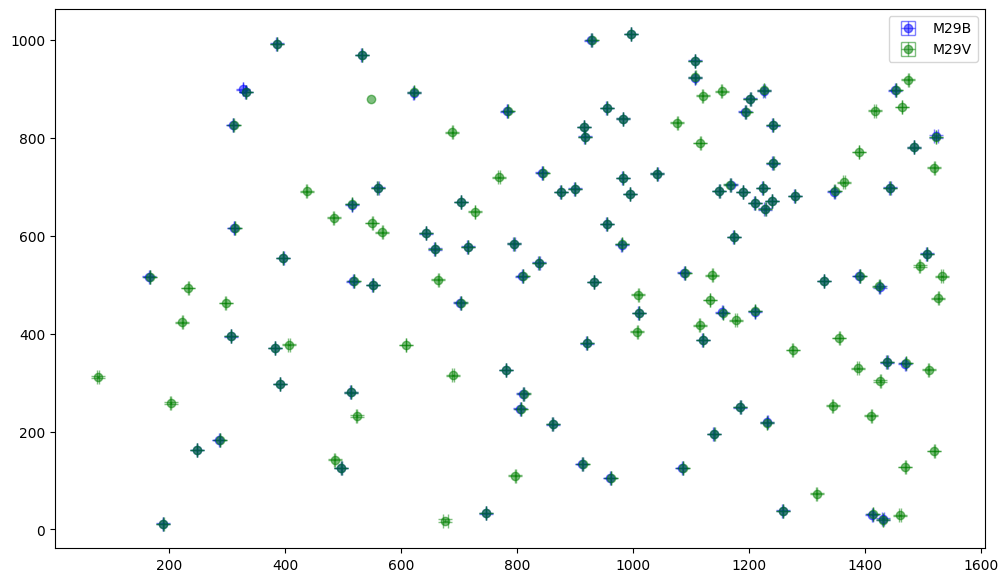

In [53]:

plt.clf()
fig = plt.figure(figsize=(12,7))
#plt.scatter(phots['M29B']['x_fit'],phots['M29B']['y_fit'], marker='o', c='blue', alpha=0.5)
#plt.scatter(phots['M29V']['x_fit'],phots['M29V']['y_fit'], marker='o', c='green',alpha=0.5)

plt.errorbar(x=phots['M29B']['x_fit'],y=phots['M29B']['y_fit'],
             xerr=phots['M29B']['x_err'],
             yerr=phots['M29B']['y_err'],fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M29B",alpha=0.5
              )
plt.errorbar(x=phots['M29V']['x_fit'],y=phots['M29V']['y_fit'],
             xerr=phots['M29V']['x_err'],
             yerr=phots['M29V']['y_err'],fmt='o', ecolor='green', elinewidth=1, capsize=5,c='green',label="M29V",alpha=0.5
              )
plt.legend()

plt.show()

## Create dataframe for both Filters

In [54]:
m29b = phots['M29B'].to_pandas()
m29v = phots['M29V'].to_pandas()

In [55]:
# function to filter out some bad points

def clean_df(data, n=0):
    # Drop rows with missing values
    df = data.dropna(inplace=False)

    # Apply the initial filtering conditions
    cond = (df['flags'] == 0) & (df['x_fit'] > 0) & (df['x_fit'] < 1536) & (df['y_fit'] > 0) & (df['y_fit'] < 1024)
    filtered_df = df[cond].copy()

    # Keep only nth lines with the highest 'flux_fit'
    if n > 0:
        filtered_df = filtered_df.nlargest(n, 'flux_fit')

    return filtered_df




In [56]:
print(f"B : {m29b.shape}")
print(f"V : {m29v.shape}")


B : (92, 17)
V : (142, 17)


In [57]:
m29b = clean_df(m29b)
m29v = clean_df(m29v)
print(f"B : {m29b.shape}")
print(f"V : {m29v.shape}")

B : (92, 17)
V : (141, 17)


In [77]:
matched_indexes_b = []
matched_indexes_v = []

margin = 1 #2 pixeis

dt_B = 45
dt_V = 70

m29 = pd.DataFrame(columns = ["Bflux", "Vflux","Bflux_err",'Vflux_err'])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i_m29v, row_m29v in m29v.iterrows():
        for i_m29b, row_m29b in m29b.iterrows():
            if abs(row_m29v['x_fit'] - row_m29b['x_fit']) < margin and abs(row_m29b['y_fit'] - row_m29v['y_fit']) < margin:

                m29 = m29.append({
                    'Bflux':row_m29b['flux_fit']/dt_B,
                    'Vflux':row_m29v['flux_fit']/dt_V,
                    'Bflux_err':row_m29b['flux_err']/dt_B,
                    'Vflux_err':row_m29v['flux_err']/dt_V
                                }, 
                                ignore_index= True)

                if (i_m29v in matched_indexes_v) or (i_m29b in matched_indexes_b):
                    print(f"Something's wrong {i_m29v} {i_m29b}")
                matched_indexes_b.append(i_m29b)
                matched_indexes_v.append(i_m29v)





In [78]:
m29.shape

(81, 4)

# HR Diagram Relative Magnitudes

<Figure size 640x480 with 0 Axes>

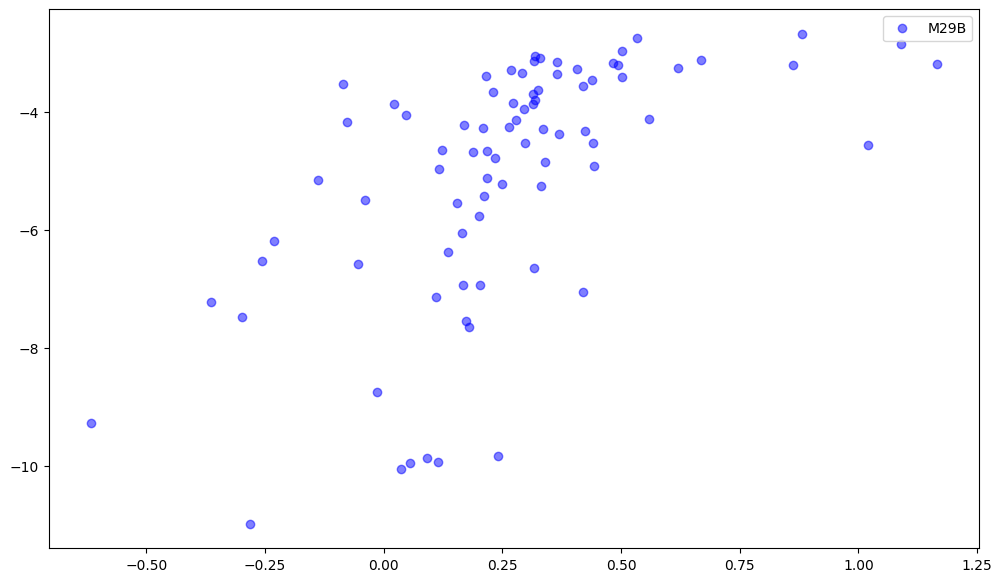

In [79]:

plt.clf()
fig = plt.figure(figsize=(12,7))

plt.errorbar(y=-2.5*np.log10(m29.Bflux),x=-2.5*np.log10(m29.Bflux/m29.Vflux),
             #xerr=phots['M29B']['x_err'],
             #yerr=phots['M29B']['y_err'],
             fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M29B",alpha=0.5
              )

plt.legend()

plt.show()

In [80]:
def calc_m (flux):
    return -2.5 * np.log10(flux)

def calc_m_err(flux, flux_err):
    return abs(-2.5/(flux*np.log(10))*flux_err)

def calc_M (m,d):
    return m - 5*np.log10(d) + 5

def calc_M_err (m_err, d , d_err):
    return np.sqrt(m_err **2 + ((-5/(d *np.log(10)))*d_err)**2 )
    


# Correct to Distance + Standard Star

In [81]:
#Standard star hip100108
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G
d_StStar=  59.791
d_StStar_err=0.1312 
M_abs_StStar_B_true = 5.64
M_abs_StStar_V_true = 5.58

StStar_Bflux = 330820.5932283057
StStar_Bflux_err= 26027.889649890487

StStar_Vflux = 706937.6199424627
StStar_Vflux_err = 54329.532996867296

m_StStar_B = calc_m(StStar_Bflux) #+instrumental zero point
m_StStar_B_err = calc_m_err(flux=StStar_Bflux, flux_err=StStar_Bflux_err)

m_StStar_V = calc_m(StStar_Vflux) #+instrumental zero point
m_StStar_V_err = calc_m_err(flux=StStar_Vflux, flux_err=StStar_Vflux_err)

print(f"Standard Star mB = {m_StStar_B} +- {m_StStar_B_err}")
print(f"Standard Star mV = {m_StStar_V} +- {m_StStar_V_err}")



Standard Star mB = -13.798981340223111 +- 0.08542219772525807
Standard Star mV = -14.623452733537508 +- 0.08344094202696588


In [82]:
M_abs_StStar_B = calc_M(m=m_StStar_B,d=d_StStar)
M_abs_StStar_B_err = calc_M_err(m_err=m_StStar_B_err,d=d_StStar,d_err=d_StStar_err)

M_abs_StStar_V = calc_M(m=m_StStar_V,d=d_StStar)
M_abs_StStar_V_err = calc_M_err(m_err=m_StStar_V_err,d=d_StStar,d_err=d_StStar_err)

print(f"Standard Star MB = {M_abs_StStar_B} +- {M_abs_StStar_B_err}")
print(f"Standard Star MV = {M_abs_StStar_V} +- {M_abs_StStar_V_err}")



Standard Star MB = -17.6821604253411 +- 0.08555498807134229
Standard Star MV = -18.506631818655496 +- 0.08357688033195494


In [83]:
inst_calib_B = M_abs_StStar_B_true - M_abs_StStar_B
inst_calib_V = M_abs_StStar_V_true - M_abs_StStar_V

inst_calib_B_err = M_abs_StStar_B_err
inst_calib_V_err = M_abs_StStar_V_err

In [84]:
m29["mB"] = calc_m(flux=m29["Bflux"])
m29["mB_err"] = calc_m_err(flux=m29["Bflux"],flux_err=m29["Bflux_err"])

m29["mV"] = calc_m(flux=m29["Vflux"])
m29["mV_err"] = calc_m_err(flux=m29["Vflux"],flux_err=m29["Vflux_err"])




In [85]:
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2021MNRAS.504..356D
d= 1785
d_err=107

MB_uncalib = calc_M(m=m29["mB"],d=d)
MB_uncalib_err = calc_M_err(m_err=m29["mB_err"],d=d,d_err=d_err)

MV_uncalib = calc_M(m=m29["mV"],d=d)
MV_uncalib_err = calc_M_err(m_err=m29["mV_err"],d=d,d_err=d_err)


In [86]:
m29["MB"] = inst_calib_B + MB_uncalib
m29["MB_err"] = np.sqrt( inst_calib_B_err**2 + MB_uncalib_err**2 )

m29["MV"] = inst_calib_V + MV_uncalib
m29["MV_err"] = np.sqrt( inst_calib_V_err**2 + MV_uncalib_err**2 )

In [87]:
m29["BV"] = m29["MB"] - m29["MV"]
m29["BV_err"] = np.sqrt( m29["MB_err"]**2 + m29["MV_err"]**2  )

<Figure size 640x480 with 0 Axes>

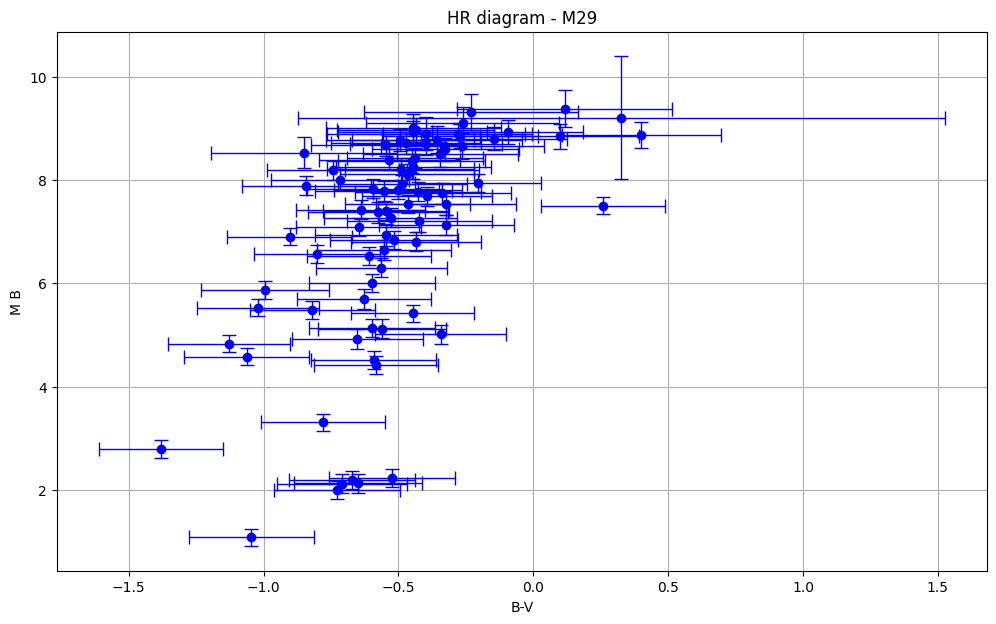

In [88]:
plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.title("HR diagram - M29")
plt.grid(True)
plt.show()

In [89]:
m29["BV"] = -2.5*np.log10(m29["Bflux"]/m29["Vflux"])

m29["BV_err"] = np.sqrt( np.square( calc_m_err(m29["Bflux"],m29["Bflux_err"] ))  +  np.square( calc_m_err(m29["Vflux"],m29["Vflux_err"] )) )

# HR Diagram

<Figure size 640x480 with 0 Axes>

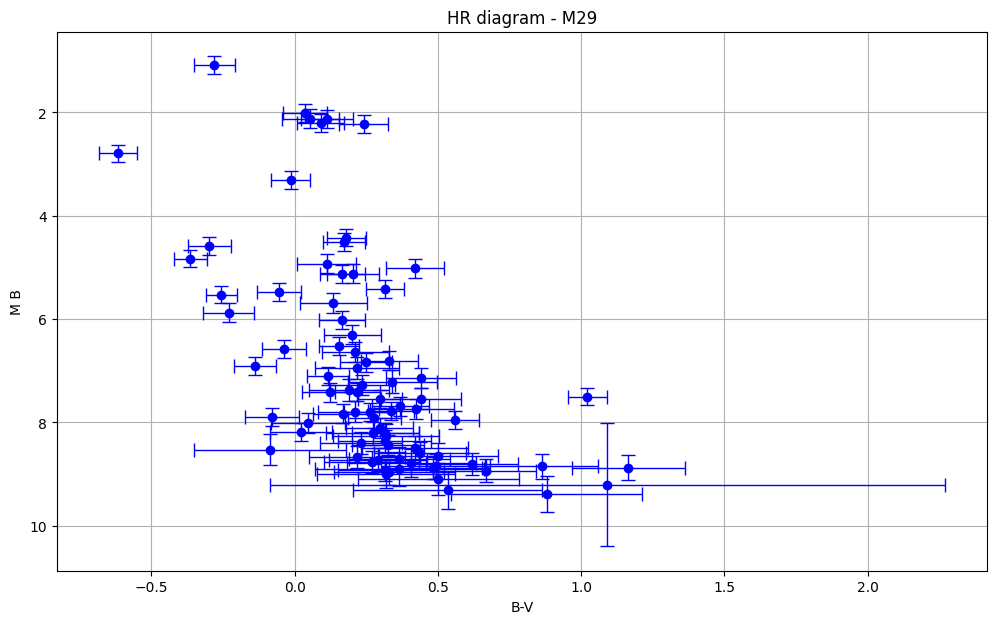

In [91]:
plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.gca().invert_yaxis()

plt.title("HR diagram - M29")
plt.grid(True)
plt.show()

## Remove points w/ bigger uncertainties

<Figure size 640x480 with 0 Axes>

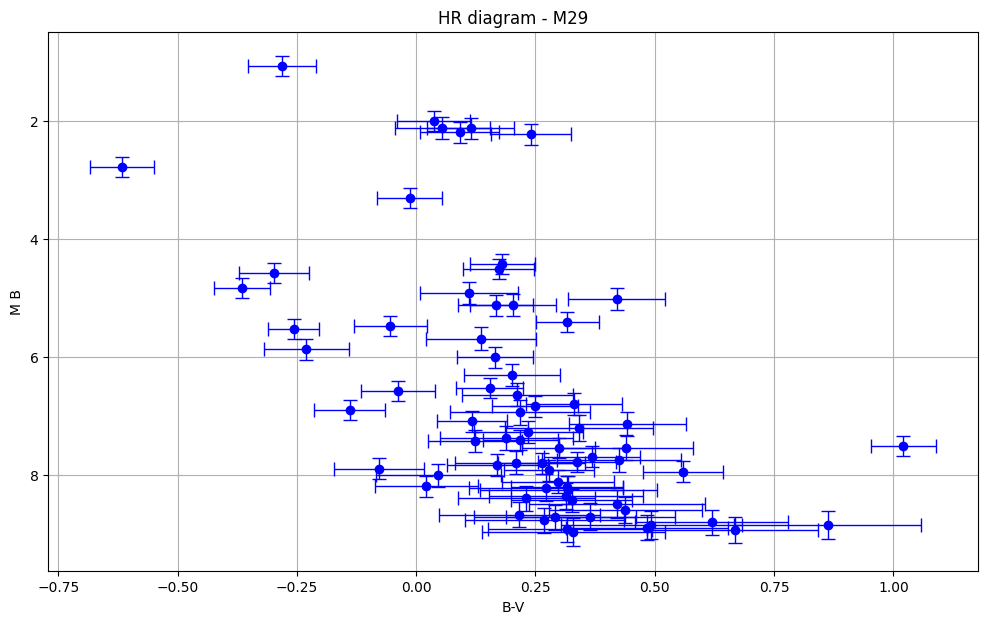

In [92]:
acc = 0.25
#condition to remove data point
m29 = m29[(m29['BV_err'] < acc) & (m29['MB_err'] < acc)]

plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.gca().invert_yaxis()

plt.title("HR diagram - M29")
plt.grid(True)
plt.show()


# Isochrone Fitting

In [96]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('data/models/isochrones.dat', format='ascii')
print(isochrones.columns)

#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e6) #in Myrs
for logage, age in zip(logages,ages): print(logage,age) #print all of that

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Umag','Bmag','Vmag','Rmag','Imag','Jmag','Hmag','Kmag')>
7.0 10.0
7.09691 12.499999625598054
7.17609 14.999956513820402
7.24304 17.50007862882901
7.30103 20.000000199681043
7.35218 22.499869541650266
7.39794 24.9999995007974
7.43933 27.499829424260362
7.47712 29.999913327161497
7.51188 32.49974848542795
7.54407 35.00015760710141
7.57403 37.4998905357492
7.60206 40.00000079872417
7.62839 42.50010470526256
7.65321 44.99973953258027
7.67669 47.499605206891204
7.69897 49.9999995007974
7.72016 52.50008420833815
7.74036 54.99965939764019
7.75967 57.500285360875914
7.77815 59.999827253364394
7.79588 62.49999750398704
7.81291 64.99949761981426
7.8293 67.4994136121949
7.8451 70.00031591308975
7.86034 72.50033277865747
7.87506 74.99978182030029
7.8893 77.49969618775764
7.90309 80.00000239617252


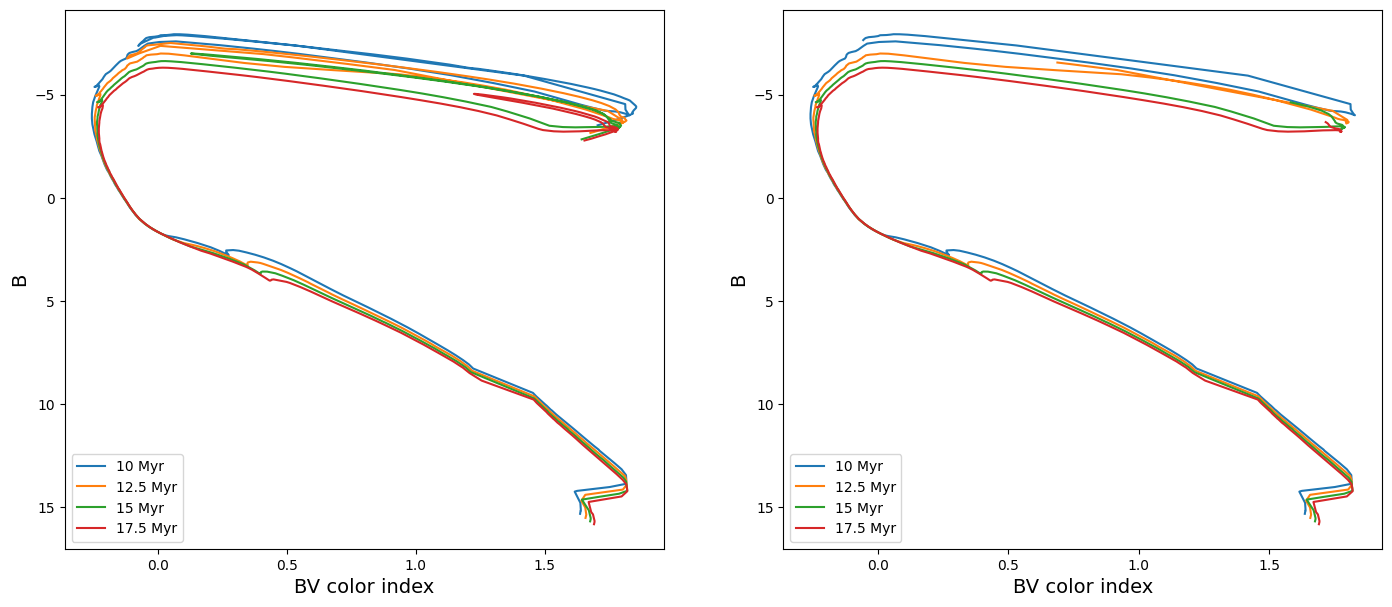

In [98]:
#you can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 7 
age_2 = isochrones['logAge'] == 7.09691 
age_3 = isochrones['logAge'] == 7.17609 
age_4 = isochrones['logAge'] == 7.24304 

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
ax1.plot(isochrones['Bmag'][age_1] - isochrones['Vmag'][age_1], isochrones['Bmag'][age_1],label='10 Myr')
ax1.plot(isochrones['Bmag'][age_2] - isochrones['Vmag'][age_2], isochrones['Bmag'][age_2],label='12.5 Myr')
ax1.plot(isochrones['Bmag'][age_3] - isochrones['Vmag'][age_3], isochrones['Bmag'][age_3],label='15 Myr')
ax1.plot(isochrones['Bmag'][age_4] - isochrones['Vmag'][age_4], isochrones['Bmag'][age_4],label='17.5 Myr')
ax1.invert_yaxis()
ax1.set_xlabel('BV color index',fontsize=14)
ax1.set_ylabel('B',fontsize=14)
ax1.legend()

#We can cut off the more evolved stages
N=250
ax2.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
ax2.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='12.5 Myr')
ax2.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='15 Myr')
ax2.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='17.5 Myr')
ax2.invert_yaxis()
ax2.set_xlabel('BV color index',fontsize=14)
ax2.set_ylabel('B',fontsize=14)
ax2.legend()

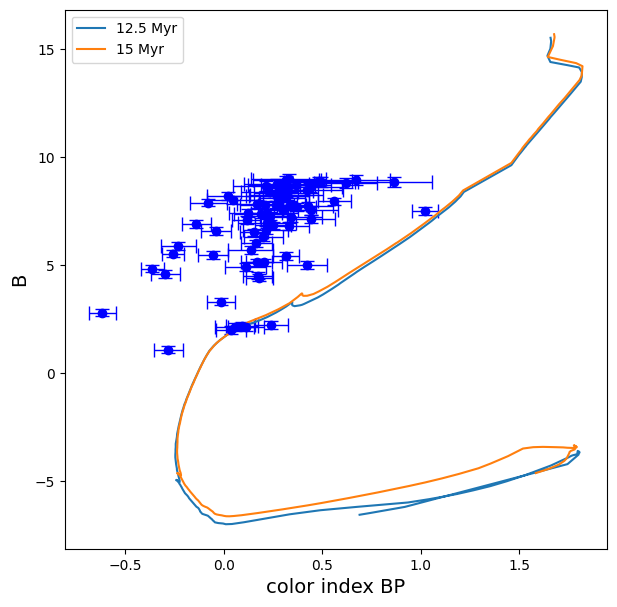

In [100]:
#Let's now plot a model on top of our data, just approximately
fig = plt.figure(figsize=(7,7))
plt.errorbar(
    x=m29["BV"],
    y=m29["MB"],
    xerr=m29["BV_err"],
    yerr=m29["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
#plt.ylim(21,2)
plt.xlabel('color index BP',fontsize=14)
plt.ylabel('B',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
#median_parallax=np.nanmedian(data['parallax'])
#dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
#DM=5*np.log10(dist)-5 #distance modulus
#print('distance modulus:',DM)
plt.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='12.5 Myr')
plt.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='15 Myr')
plt.legend()
#print(dist)

In [ ]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])

#distance
dmin,dmax,step=200,300,10
distances = np.arange(dmin,dmax,step)

#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):

        ## model
        distance=distances[j]
        DM=5*np.log10(distance)-5 #distance modulus
        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['G_BPmag'] - isochrone['G_RPmag'] #color isochrone
        mag_iso = isochrone['Gmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        ## data
        d=np.empty(len(data))
        for k in range(len(data)):
            col_data=data['bp_rp'][k]
            mag_data=data['phot_g_mean_mag'][k]
            point=Point(col_data,mag_data)
            d[k] = point.distance(line) #shortest distance of the point to the line of the isochrone
        rmsd[i,j]=np.sqrt(np.nanmean(d)**2)

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)
